In [1]:
import sys

sys.path.insert(0, '..')

import os
import requests
import json
from tempfile import mkdtemp
from urllib.request import urlretrieve
import libsbml
import amici
import os
from biosimulator_processes.utils import prepare_single_ode_process_document
from biosimulator_processes.data_model.compare_data_model import ODEComparisonDocument, DocumentFactory
from biosimulator_processes import CORE
from process_bigraph import Composite, pp

CobraProcess registered successfully.
CopasiProcess registered successfully.
_CopasiProcess registered successfully.
SmoldynProcess registered successfully.
TelluriumProcess registered successfully.
AmiciProcess registered successfully.
ODEComparatorProcess registered successfully.
GetSbmlStep registered successfully.
CompositionPlotter registered successfully.
Plotter2d registered successfully.
ODEComparatorStep registered successfully.


In [2]:
process_name = 'copasi'
module_name = f'{process_name}_process'
import_statement = f'biosimulator_processes.processes.{module_name}'
module_paths = module_name.split('_')
class_name = module_paths[0].replace(module_name[0], module_name[0].upper())
class_name += module_paths[1].replace(module_paths[1][0], module_paths[1][0].upper())


class_name, module_paths[1][0].upper()

('CopasiProcess', 'P')

In [3]:
module = __import__(
    import_statement, fromlist=[class_name])
# Get the class from the module
bigraph_class = getattr(module, class_name)

In [4]:
process = bigraph_class(config={'model': {'model_source': 'BIOMD0000000630'}})

found a biomodel id


In [5]:
# Step 1: Define the input parameters of the api method

biomodel_id = 'BIOMD0000000630'
sbml_dirpath = '../biosimulator_processes/model_files/sbml'
model_fp = os.path.join(sbml_dirpath, f'{biomodel_id}_url.xml')
species_context = 'concentrations'
species_port_name = f'floating_species_{species_context}'
species_store = [f'floating_species_{species_context}_store']
duration = 30
n_steps = 42
simulators = ['copasi', 'tellurium']

In [6]:
# Step 2: Define a simple function that encapsulates that which is defined in the rest of the workflow

def generate_ode_verification(biomodel_id, dur) -> dict:
    compare = {
        'compare_ode': {
                '_type': 'step',
                  'address': 'local:compare_ode_step',
                  'config': {'biomodel_id': biomodel_id, 'duration': dur},
                  'inputs': {},
                  'outputs': {
                    'comparison_data': ['comparison_store']
                }
        },
        'verification_data': {
                 '_type': 'step',
                  'address': 'local:ram-emitter',
                  'config': {
                      'emit': {
                          'comparison_data': 'tree[any]'
                      }
                  },
                  'inputs': {
                      'comparison_data': ['comparison_store']
                  }
        }
    }
    
    
    wf = Composite(config={'state': compare}, core=CORE)
    wf.run(1)
    comparison_results = wf.gather_results()
    return comparison_results, wf

In [7]:
# Step 3: View the results. TODO: Add RMSE here.

verification_results, wf = generate_ode_verification(biomodel_id, duration)

pp(verification_results)

2024-05-15 15:01:38.492 - amici.sbml_import - INFO - Finished importing SBML                         (2.84E-02s)
2024-05-15 15:01:38.517 - amici.sbml_import - INFO - Finished processing SBML observables            (2.19E-02s)
2024-05-15 15:01:38.520 - amici.sbml_import - INFO - Finished processing SBML event observables      (8.75E-07s)
2024-05-15 15:01:38.542 - amici.de_model - INFO - Finished computing xdot                            (2.35E-03s)
2024-05-15 15:01:38.546 - amici.de_model - INFO - Finished computing x0                              (1.56E-03s)
2024-05-15 15:01:38.554 - amici.de_model - INFO - Finished computing w                               (5.65E-03s)


found a filepath


2024-05-15 15:01:38.950 - amici.de_export - INFO - Finished generating cpp code                      (3.92E-01s)
2024-05-15 15:01:48.538 - amici.de_export - INFO - Finished compiling cpp code                       (9.59E+00s)
/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/../biosimulator_processes/processes/copasi_process.py:205: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



{ ('verification_data',): [ { 'comparison_data': { ('emitter',): [ { 'amici_simple_floating_species_concentrations': { 'plasmin': 0.0,
                                                                                                                       'plasminogen': 0.0,
                                                                                                                       'single intact chain urokinase-type plasminogen activator': 0.0,
                                                                                                                       'two-chain urokinase-type plasminogen activator': 0.0,
                                                                                                                       'x': 0.0,
                                                                                                                       'x-plasmin': 0.0},
                                                                     'copasi_simple_floating_species_

In [8]:
verification_results

{('verification_data',): [{'comparison_data': {('emitter',): [{'copasi_simple_floating_species_concentrations': {'plasminogen': 0.0,
       'plasmin': 0.0,
       'single intact chain urokinase-type plasminogen activator': 0.0,
       'two-chain urokinase-type plasminogen activator': 0.0,
       'x': 0.0,
       'x-plasmin': 0.0},
      'amici_simple_floating_species_concentrations': {'plasminogen': 0.0,
       'plasmin': 0.0,
       'single intact chain urokinase-type plasminogen activator': 0.0,
       'two-chain urokinase-type plasminogen activator': 0.0,
       'x': 0.0,
       'x-plasmin': 0.0},
      'tellurium_simple_floating_species_concentrations': {'species_1': 0.0,
       'species_2': 0.0,
       'species_3': 0.0,
       'species_4': 0.0},
      'time': 0.0},
     {'copasi_simple_floating_species_concentrations': {'plasminogen': 1.1758171177387002e+16,
       'plasmin': 1096150505274.1506,
       'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,

In [9]:
"""TODO: Update the input/output schema of the ODEComparatorProcess to mimic the following:

{('emitter',): [{
    'copasi': [
        {
            'floating_species_concentrations': {
                'plasminogen': 0.0,
                'plasmin': 0.0,
                'single intact chain urokinase-type plasminogen activator': 0.0,
                'two-chain urokinase-type plasminogen activator': 0.0,
                'x': 0.0,
                'x-plasmin': 0.0},
           'time': 0.0
        },
        ...
    ],
    'amici': [
        {
            'floating_species_concentrations': {
                'plasminogen': 1.1758171177387002e+16,
                'plasmin': 1096150505274.1506,
                'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,
                'two-chain urokinase-type plasminogen activator': 80249.33829510311,
                'x': 0.0,
                'x-plasmin': 0.0},
           'time': 0.0},
        },
       ...
    ]


"""

"TODO: Update the input/output schema of the ODEComparatorProcess to mimic the following:\n\n{('emitter',): [{\n    'copasi': [\n        {\n            'floating_species_concentrations': {\n                'plasminogen': 0.0,\n                'plasmin': 0.0,\n                'single intact chain urokinase-type plasminogen activator': 0.0,\n                'two-chain urokinase-type plasminogen activator': 0.0,\n                'x': 0.0,\n                'x-plasmin': 0.0},\n           'time': 0.0\n        },\n        ...\n    ],\n    'amici': [\n        {\n            'floating_species_concentrations': {\n                'plasminogen': 1.1758171177387002e+16,\n                'plasmin': 1096150505274.1506,\n                'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,\n                'two-chain urokinase-type plasminogen activator': 80249.33829510311,\n                'x': 0.0,\n                'x-plasmin': 0.0},\n           'time': 0.0},\n        },\n 

In [10]:
wf

In [11]:
wf.state.keys()

dict_keys(['compare_ode', 'verification_data', 'global_time', 'comparison_store'])

In [12]:
emitter = wf.state['verification_data']['instance']

In [13]:
emitter.history

[{'comparison_data': {('emitter',): [{'copasi_simple_floating_species_concentrations': {'plasminogen': 0.0,
      'plasmin': 0.0,
      'single intact chain urokinase-type plasminogen activator': 0.0,
      'two-chain urokinase-type plasminogen activator': 0.0,
      'x': 0.0,
      'x-plasmin': 0.0},
     'amici_simple_floating_species_concentrations': {'plasminogen': 0.0,
      'plasmin': 0.0,
      'single intact chain urokinase-type plasminogen activator': 0.0,
      'two-chain urokinase-type plasminogen activator': 0.0,
      'x': 0.0,
      'x-plasmin': 0.0},
     'tellurium_simple_floating_species_concentrations': {'species_1': 0.0,
      'species_2': 0.0,
      'species_3': 0.0,
      'species_4': 0.0},
     'time': 0.0},
    {'copasi_simple_floating_species_concentrations': {'plasminogen': 1.1758171177387002e+16,
      'plasmin': 1096150505274.1506,
      'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,
      'two-chain urokinase-type plasminogen

In [14]:
wf.state['global_time']

1.0

In [15]:
outputs_1 = {
      "interval_id": 1,
      "copasi_floating_species_concentrations": {
        "plasminogen": 11758171177387002,
        "plasmin": 1096150505274.1506,
        "single intact chain urokinase-type plasminogen activator": 2955755808974603,
        "two-chain urokinase-type plasminogen activator": 80249.33829510311,
        "x": 0,
        "x-plasmin": 0
      },
      "tellurium_floating_species_concentrations": {
        "species_1": 0.009841338446759926,
        "species_2": 3.50091366956004e-7,
        "species_3": 0.003069285532211755,
        "species_4": 1.9636710780672987e-15
      },
      "amici_floating_species_concentrations": {
        "plasminogen": 0.01,
        "plasmin": 0,
        "single intact chain urokinase-type plasminogen activator": 0.002,
        "two-chain urokinase-type plasminogen activator": 0,
        "x": 0,
        "x-plasmin": 0
      },
      "time": 3
}

In [16]:
from biosimulator_processes.steps.comparator_step import generate_ode_process_comparison_matrix

species_data_index = 0

results = generate_ode_process_comparison_matrix(outputs_copasi=list(outputs_1['copasi_floating_species_concentrations'].values())[species_data_index],
                                                 outputs_amici=list(outputs_1['amici_floating_species_concentrations'].values())[species_data_index],
                                                 outputs_tellurium=list(outputs_1['tellurium_floating_species_concentrations'].values())[species_data_index])

ImportError: cannot import name 'generate_ode_process_comparison_matrix' from 'biosimulator_processes.steps.comparator_step' (/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/../biosimulator_processes/steps/comparator_step.py)

In [ ]:
results

In [ ]:
from biosimulator_processes.data_model import DescriptiveArray
import numpy as np
import pandas as pd


output_copasi = DescriptiveArray(np.random.random(100), description='copasi output', process_id='simple_copasi')
output_tellurium = DescriptiveArray(np.random.random(100), description='tell output', process_id='simple_tellurium')

output_copasi.metadata, output_tellurium.metadata

In [ ]:
raw_outputs_matrix = np.stack([output_copasi, output_tellurium])

raw_outputs_matrix

In [ ]:
raw_outputs_df = pd.DataFrame(
    raw_outputs_matrix, 
    columns=[f'param_{str(n)}' for n in range(raw_outputs_matrix.shape[1])],
    index=[output_copasi.metadata['process_id'], output_tellurium.metadata['process_id']])

In [ ]:
raw_outputs_df

In [ ]:
transposed_outputs_df = raw_outputs_df.transpose()

transposed_outputs_df

In [ ]:
transposed_outputs_df.index

In [ ]:
def calc_comparison(a, b):
    return (a - b) ** 2

In [ ]:
transposed_comparisons = dict(zip(transposed_outputs_df.index, 
                                  [calc_comparison(*output_vals) for output_vals in transposed_outputs_df.values]))

In [ ]:
for outputs in raw_outputs_matrix:
    print(outputs)

In [ ]:
transposed_comparisons

In [ ]:
comparison_data = {
    ('copasi', 'tellurium'): transposed_comparisons
}

In [ ]:
comparison_data

In [18]:
import json 
from biosimulator_processes.data_model.compare_data_model import ODEComparisonResult


with open('/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_outputs/test_ode_comparison_object.json', 'r') as f:
    output_data_response = json.load(f)

data_config = output_data_response.copy()
data_config.pop('outputs')
data_config.pop('timestamp')
    
    
output_data = ODEComparisonResult(**data_config)

2024-05-15 15:03:41.749 - amici.sbml_import - INFO - Finished loading SBML                           (4.71E-03s)
2024-05-15 15:03:41.769 - amici.sbml_import - INFO - Finished importing SBML                         (1.80E-02s)
2024-05-15 15:03:41.776 - amici.sbml_import - INFO - Finished processing SBML observables            (4.76E-03s)
2024-05-15 15:03:41.778 - amici.sbml_import - INFO - Finished processing SBML event observables      (6.67E-07s)
2024-05-15 15:03:41.795 - amici.de_model - INFO - Finished computing xdot                            (1.68E-03s)
2024-05-15 15:03:41.798 - amici.de_model - INFO - Finished computing x0                              (9.53E-04s)
2024-05-15 15:03:41.803 - amici.de_model - INFO - Finished computing w                               (3.78E-03s)


found a filepath


2024-05-15 15:03:42.041 - amici.de_export - INFO - Finished generating cpp code                      (2.35E-01s)
2024-05-15 15:03:50.574 - amici.de_export - INFO - Finished compiling cpp code                       (8.53E+00s)
/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/../biosimulator_processes/processes/copasi_process.py:205: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [19]:
def extract_unique_output_names(output_data: ODEComparisonResult) -> list[str]:   
    output_names = []
    for i, interval_output in enumerate(output_data.outputs):
        output_attributes = vars(interval_output)
        for output_attribute_key, output_value in output_attributes.items():
            if isinstance(output_value, dict):
                output_names.append(output_attribute_key)
    return list(set(output_names))
    

In [20]:
extract_unique_output_names(output_data)

['copasi_floating_species_concentrations',
 'tellurium_floating_species_concentrations',
 'amici_floating_species_concentrations']

In [21]:
from biosimulator_processes.steps.comparator_step import construct_process_interval_matrix

In [43]:
import numpy as np
import random
import pandas as pd


output_copasi = np.array([1.3, 2.4, 4.3])
output_tellurium = np.array([1.3, 2.4, 4.5])
output_amici = np.array([1.3, 2.4, 4.6])

simulators = ['copasi', 'tellurium', 'amici']

interval_data = dict(zip(simulators, [output_copasi, output_tellurium, output_amici]))

interval_data['time_id'] = random.randint(0, 400)

matrix = construct_process_interval_matrix(
    outputs_copasi=interval_data['copasi'],
    outputs_tellurium=interval_data['tellurium'],
    outputs_amici=interval_data['amici'],
    time_id=interval_data['time_id'],
    rtol=1e-05,
    atol=1e-08,
)


matrix_df = pd.DataFrame(matrix, index=simulators, columns=simulators)

matrix_df, np.allclose(output_copasi, output_tellurium, atol=0.28)

(           copasi  tellurium  amici
 copasi       True      False  False
 tellurium   False       True  False
 amici       False      False   True,
 True)

In [70]:
tolerance_range = np.linspace(0, 1, 1000)

all_close_data = []

for i, tolerance in enumerate(tolerance_range):
    tol_data = np.allclose(output_copasi, output_tellurium, atol=tolerance)
    all_close_data.append(int(tol_data))

In [71]:
y_data = all_close_data
x_data = list(range(len(all_close_data)))

len(x_data), len(y_data)

(1000, 1000)

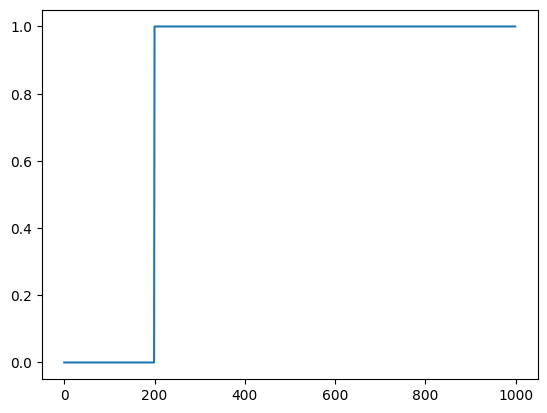

In [72]:
import matplotlib.pyplot as plt

plt.plot(x_data, y_data)

plt.show()

In [28]:
comparison_matrices = []

for i, output in enumerate(output_data.outputs):
    output_attributes = vars(output)
    for dataKey, dataVals in output_attributes.items():
        if isinstance(dataVals, dict):
            print(f'is dict: {dataKey}')
            interval_data_dict = dataVals 
            for k, v in interval_data_dict.items():
                pass

is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_species_concentrations
is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_species_concentrations
is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_species_concentrations
is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_species_concentrations
is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_species_concentrations
is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_species_concentrations
is dict: copasi_floating_species_concentrations
is dict: tellurium_floating_species_concentrations
is dict: amici_floating_s